# Выбор локации для скважины

## Вводная часть

<a id='1-topoc'></a>

### Описание проекта

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Проанализируйте возможную прибыль и риски техникой Bootstrap.

____

### Цель исследования

 Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

____

### Задачи исследования

- В избранном регионе найти месторождения, для каждого определяют значения признаков;
- Построить модель и оценивают объём запасов;
- Выбрать месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

____

### Исходные данные


Для этой задачи заказчик предоставил данные с признаками
Данные геологоразведки трёх регионов находятся в файлах: 

- geo_data_0.csv. 
- geo_data_1.csv. 
- geo_data_2.csv. 

Где: 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

____

### Ход исследования

[Вводная часть](#1-topoc)

[Загрузка данных](#2-topoc)

[Предобработка данных](#3-topoc)

[Исследовательский анализ](#4-topoc)

[Обучение моделей](#5-topoc)

[Подготовка к расчету прибыли](#6-topoc)

[Расчет прибыли](#7-topoc)

[Расчет рисков](#8-topoc)

[Общий вывод](#9-topoc)

<a id='2-topoc'></a>
## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib as mp
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     RandomizedSearchCV,
                                     cross_val_score)

    

from sklearn.preprocessing import (OrdinalEncoder,
                                   RobustScaler,
                                   OneHotEncoder,
                                   StandardScaler,
                                   LabelEncoder,
                                   MinMaxScaler)
    
from sklearn.linear_model import LinearRegression

# metrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import f1_score 
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

sns.set(style = 'whitegrid')
sns.set(rc={'figure.figsize':(16,9)})
sns.set_context('paper', rc={'font.size': 10,
                             'axes.titlesize': 10,
                             'xtrick.labelsize': 'small',
                             'ytrick.labelsize': 'small',
                             'legend.fontsize': 'small',
                             'legend.title_fontsize':10})

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Предварительное изучение

In [4]:
data = {
    'geo_data_0':geo_data_0,
    'geo_data_1':geo_data_1,
    'geo_data_2':geo_data_2
    
}

In [5]:
for i in data:
    print(i,'\n\n',data[i].head(),'\n\n',data[i].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
geo_data_0 

       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0     

#### Вывод

Данные предоставлены хорошего качества, хорошо структурированы. Пропусков не обнаружено, название столбцов соответствует стандартам.

<a id='3-topoc'></a>
## Предобработка данных

In [6]:
for i in data:
    print('Сумма полных дубликатов по датасету',i,':',data[i].duplicated().sum())
print('\n') 

data_1=data.copy()
for i in data_1:
    data_1[i] = data[i].set_index('id')
    print('Сумма полных дубликатов без индексов, датасет',i,':',data_1[i].duplicated().sum())

Сумма полных дубликатов по датасету geo_data_0 : 0
Сумма полных дубликатов по датасету geo_data_1 : 0
Сумма полных дубликатов по датасету geo_data_2 : 0


Сумма полных дубликатов без индексов, датасет geo_data_0 : 0
Сумма полных дубликатов без индексов, датасет geo_data_1 : 0
Сумма полных дубликатов без индексов, датасет geo_data_2 : 0


geo_data_0
f0


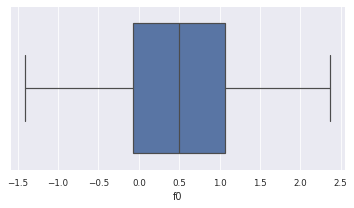

f1


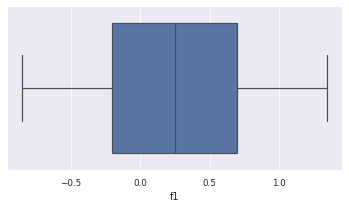

f2


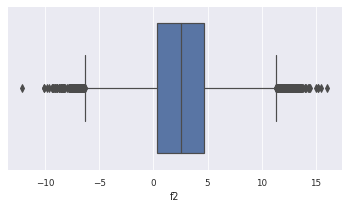

product


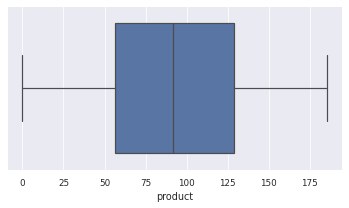

geo_data_1
f0


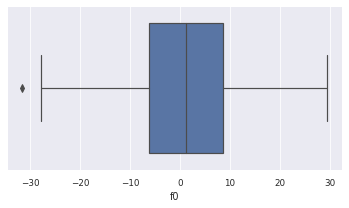

f1


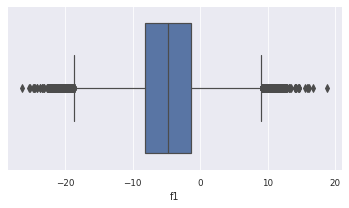

f2


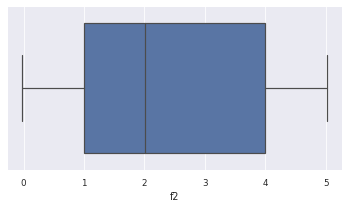

product


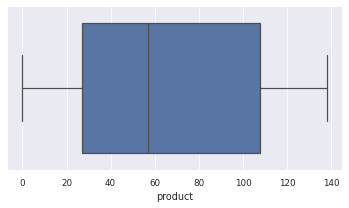

geo_data_2
f0


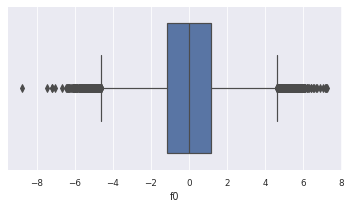

f1


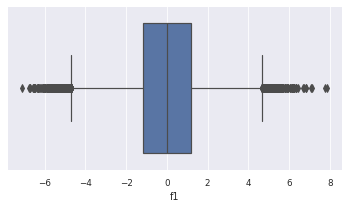

f2


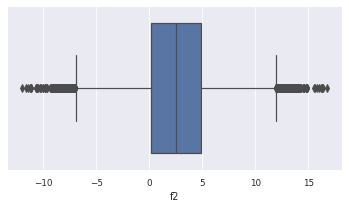

product


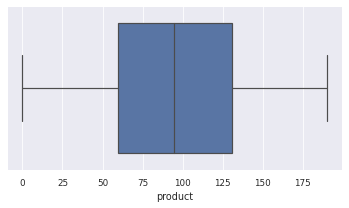

In [7]:
for name, df in data.items(): 
    print(name)
    for col in df.columns: 
        if df[col].dtype in ['int64', 'float64']:
            print(col)
            plt.figure(figsize=(6,3)) 
            sns.boxplot(x=df[col]) 
            plt.show() 

#### Вывод

Полных или не полных дубликатов в датасетах не выявлено. Так как мы не обладаем подробной информацией о показателях в датасетах, суждений о выбросах не производится. Явных анамалий также не обнаружено.

<a id='4-topoc'></a>
## Исследовательский анализ данных

f0


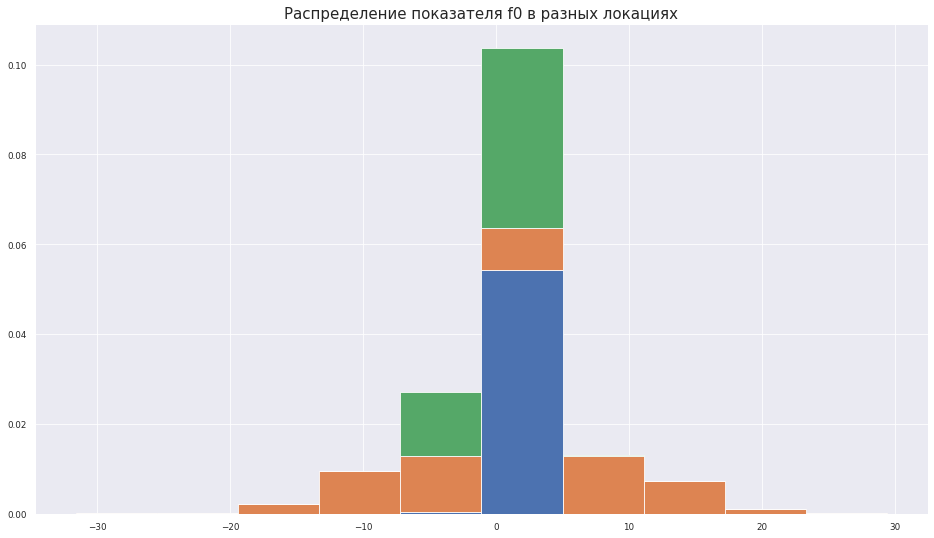

f1


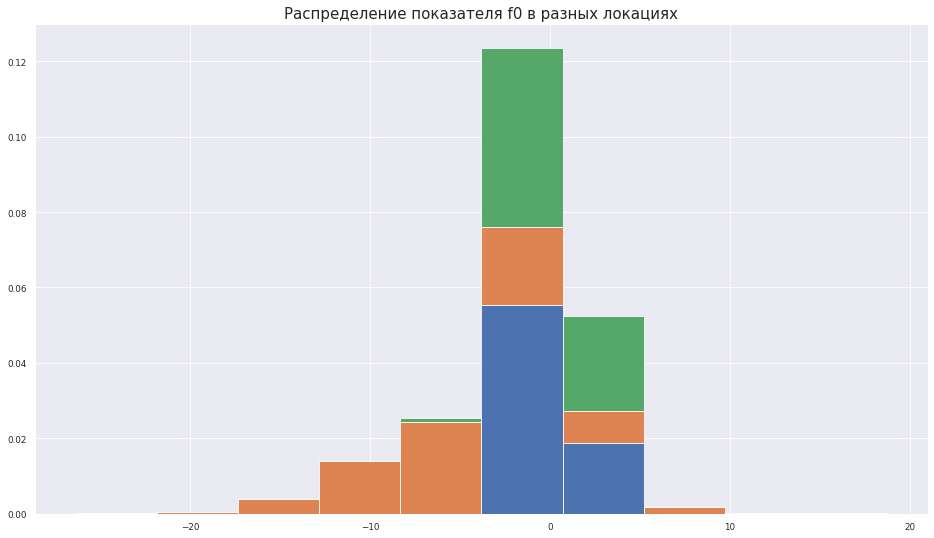

f2


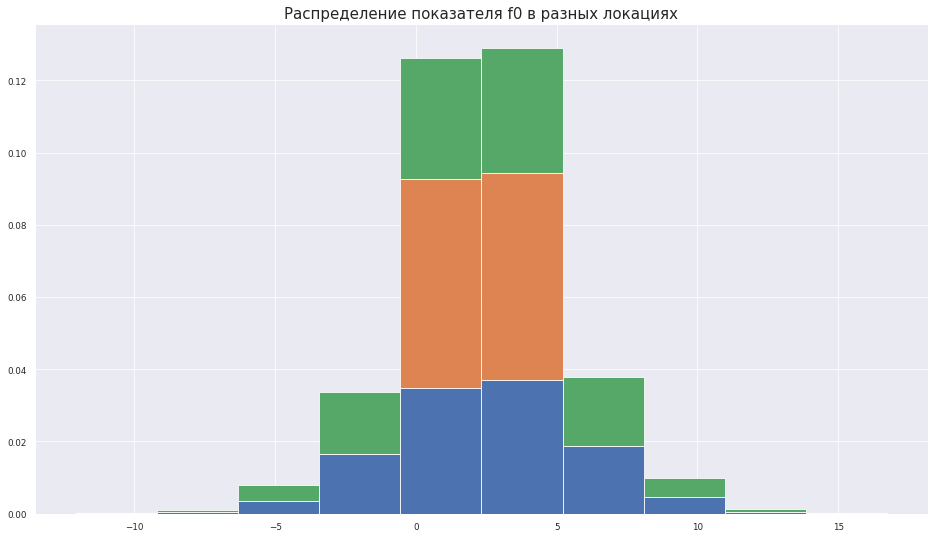

product


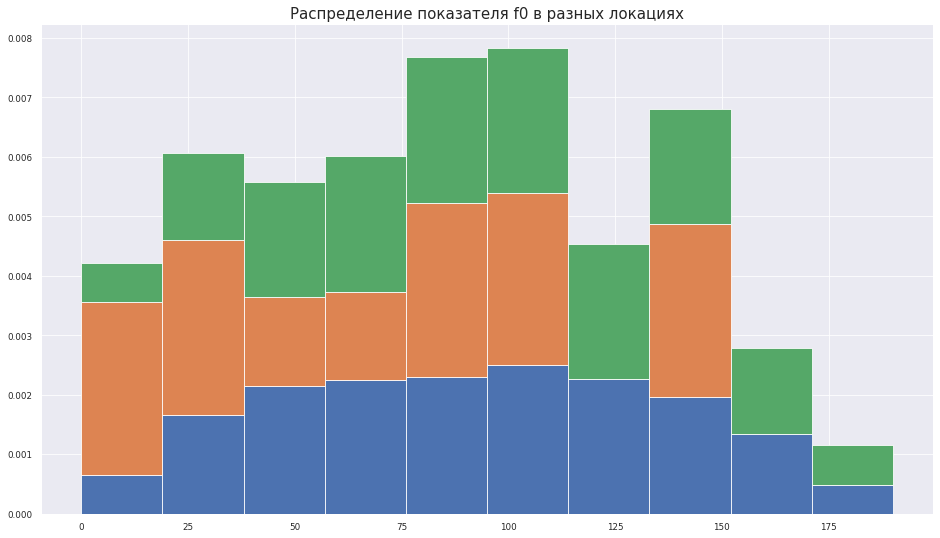

In [8]:
f0_plot = pd.DataFrame()
f1_plot = pd.DataFrame()
f2_plot = pd.DataFrame()
product_plot = pd.DataFrame()

for name,df in data.items():
    for col in df.columns:
        if col=='f0':
            f0_plot[name] = df[col]
        elif col=='f1':
            f1_plot[name] = df[col]   
        elif col=='f2':
            f2_plot[name] = df[col]
        else:
            product_plot[name] = df[col]
            
n_bins=10

plots = {
    'f0':f0_plot,
    'f1':f1_plot,
    'f2':f2_plot,
    'product':product_plot,
}
names = ['0','1','2']
for name,df in plots.items():
    print(name)
    
    plt.hist(df, n_bins, density=True, histtype='bar', stacked=True, label=names)
    plt.title('Распределение показателя f0 в разных локациях',fontsize=15)
    plt.show()


Распределение показателя:  f0 





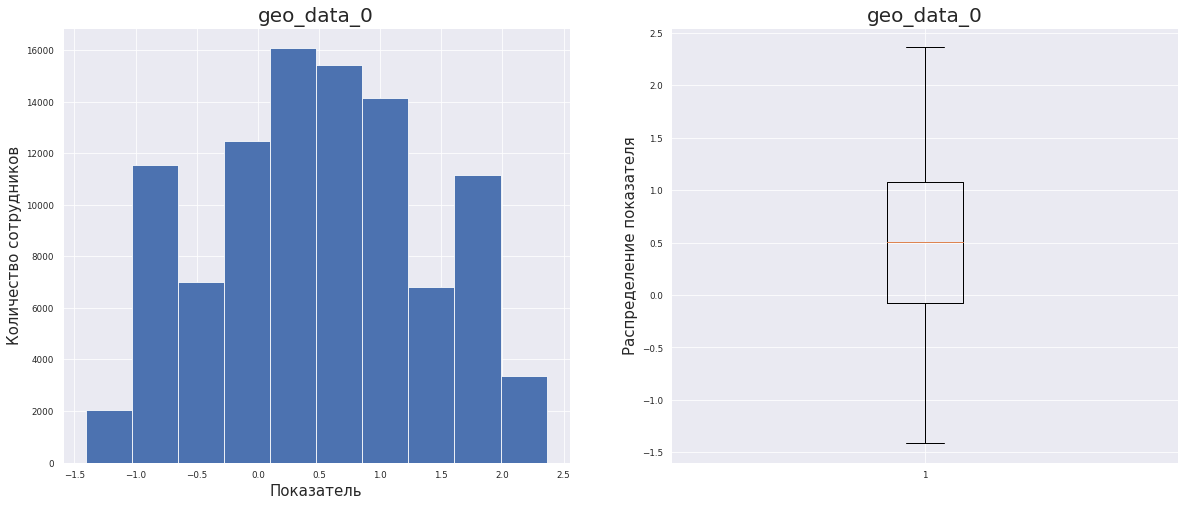

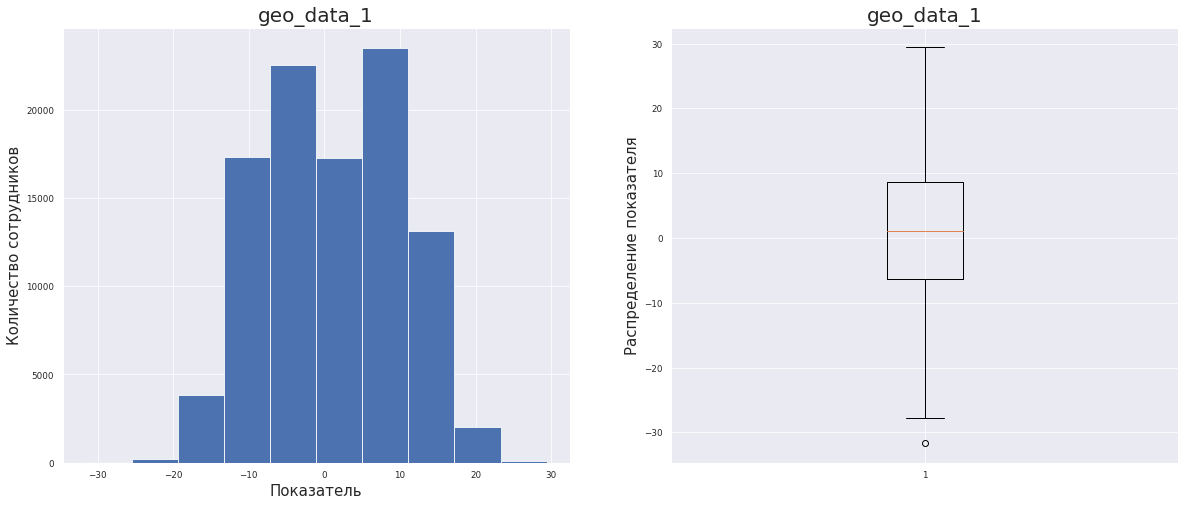

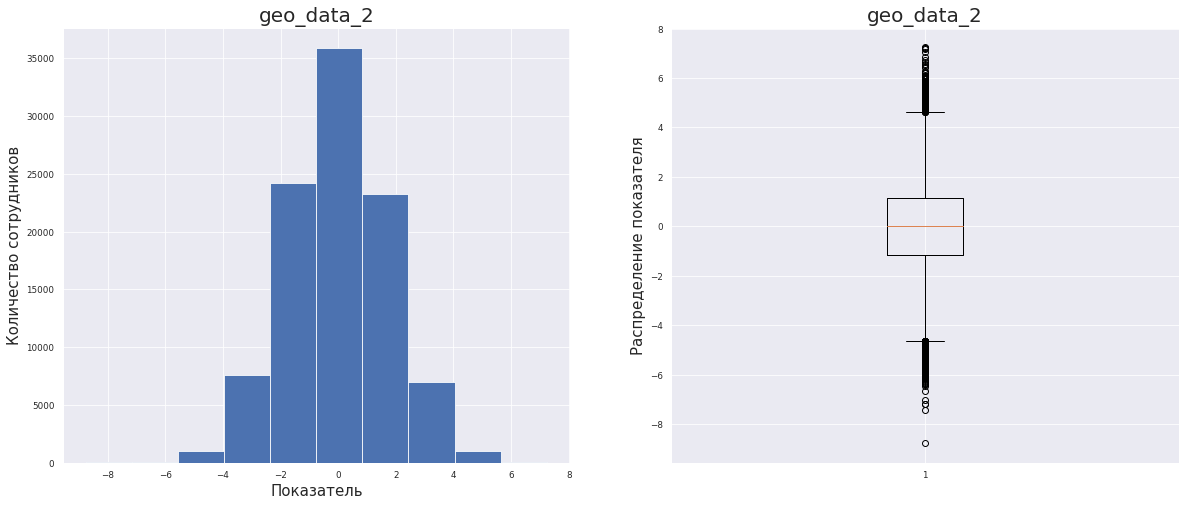

Распределение показателя:  f1 





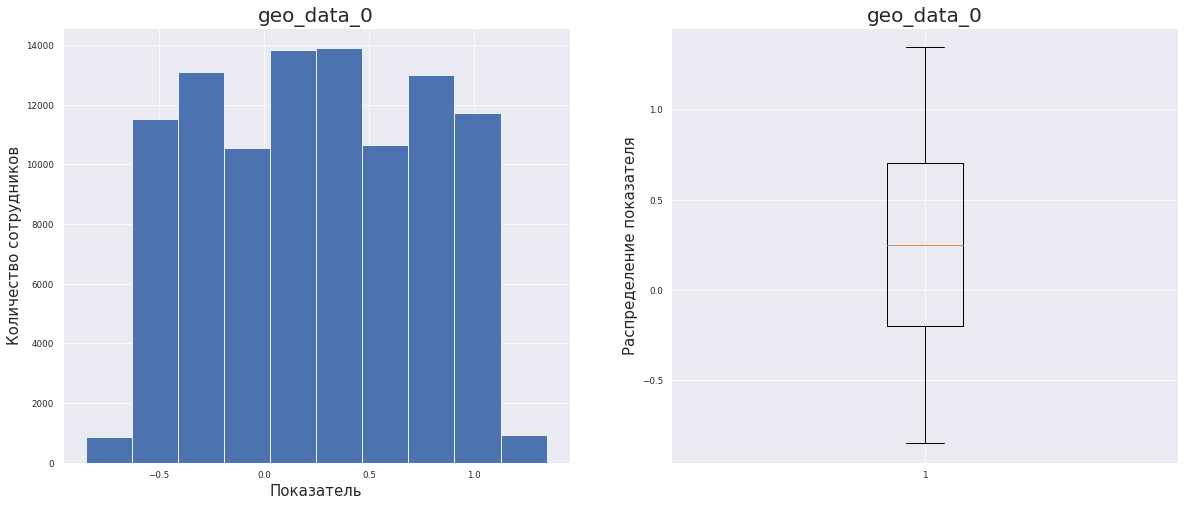

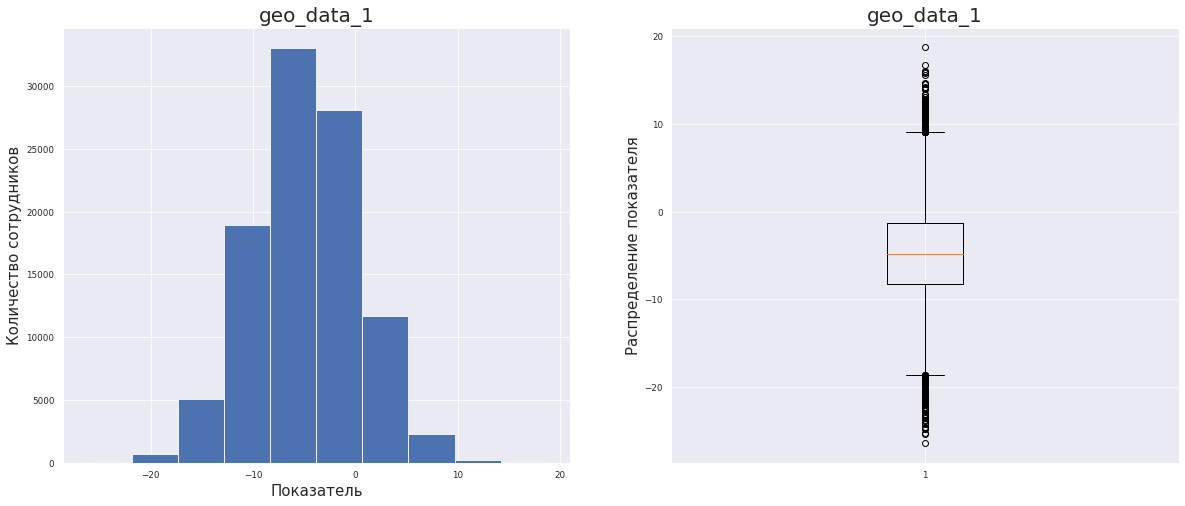

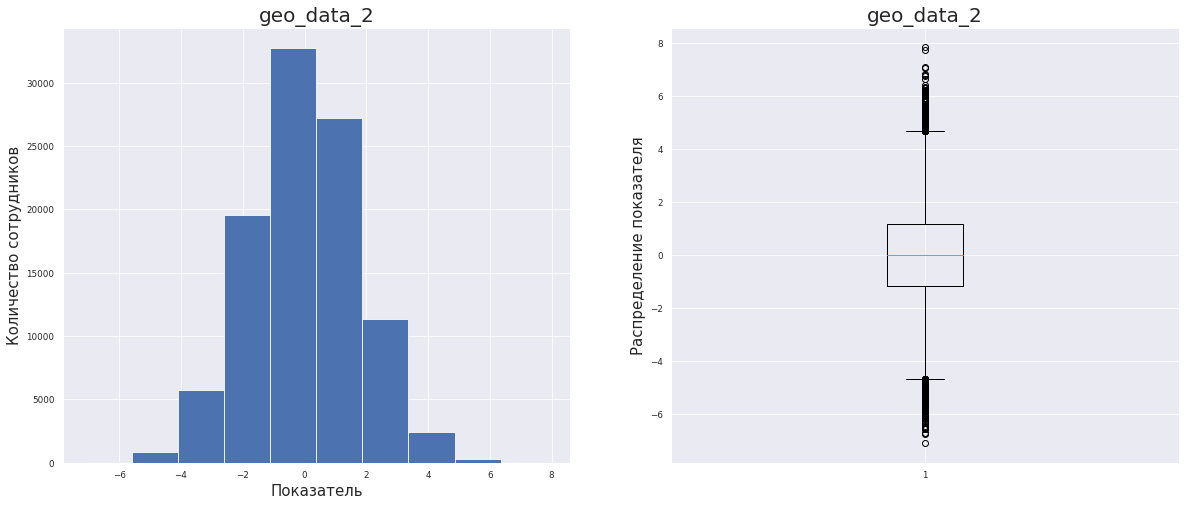

Распределение показателя:  f2 





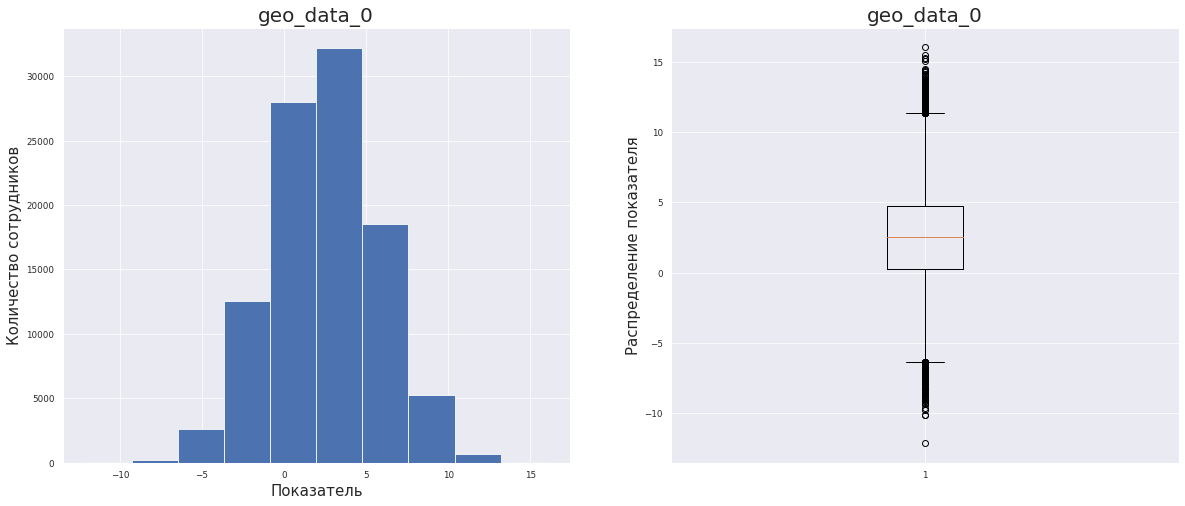

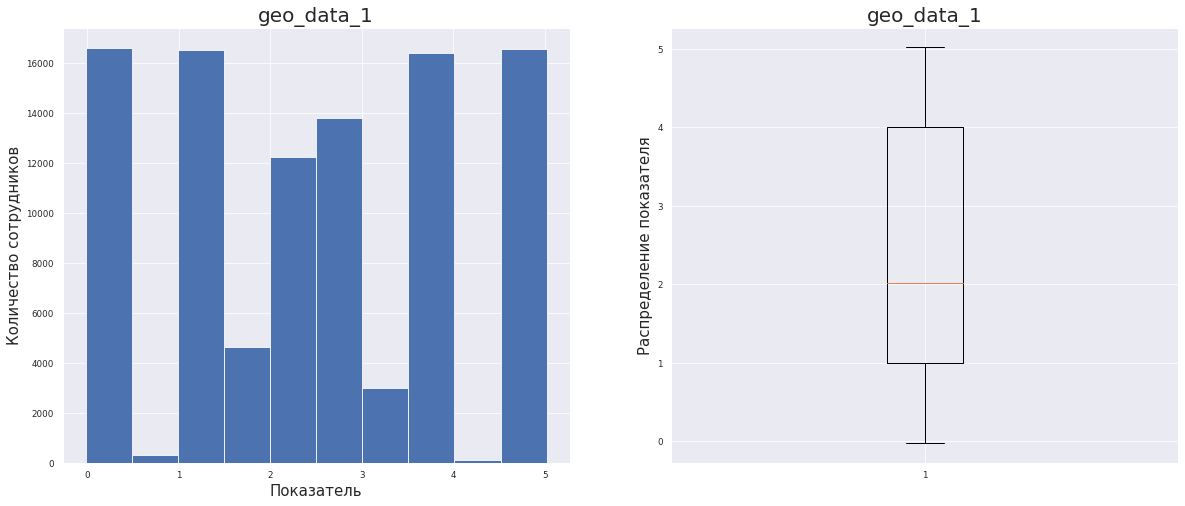

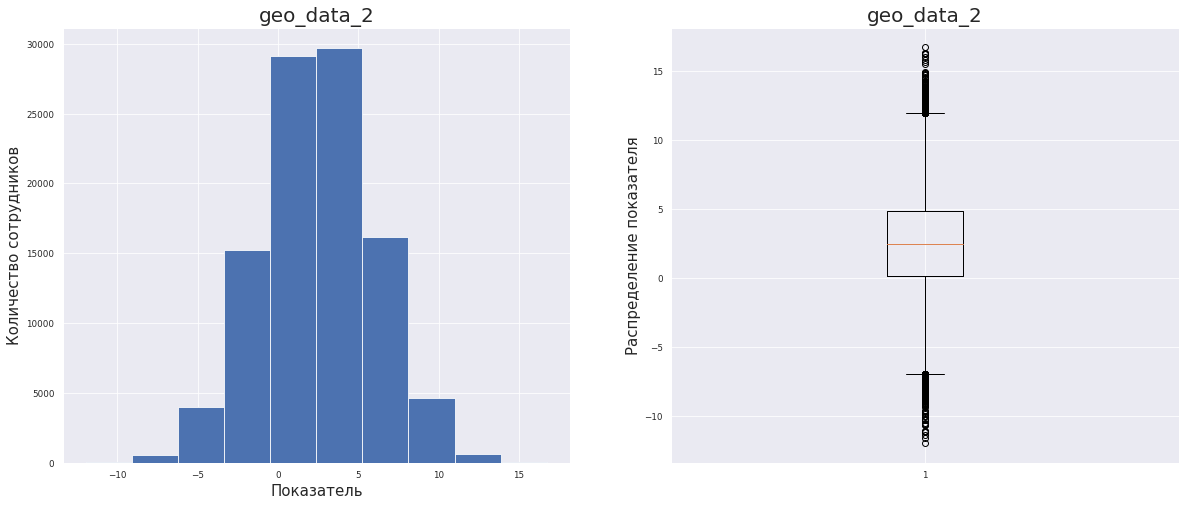

Распределение показателя:  product 





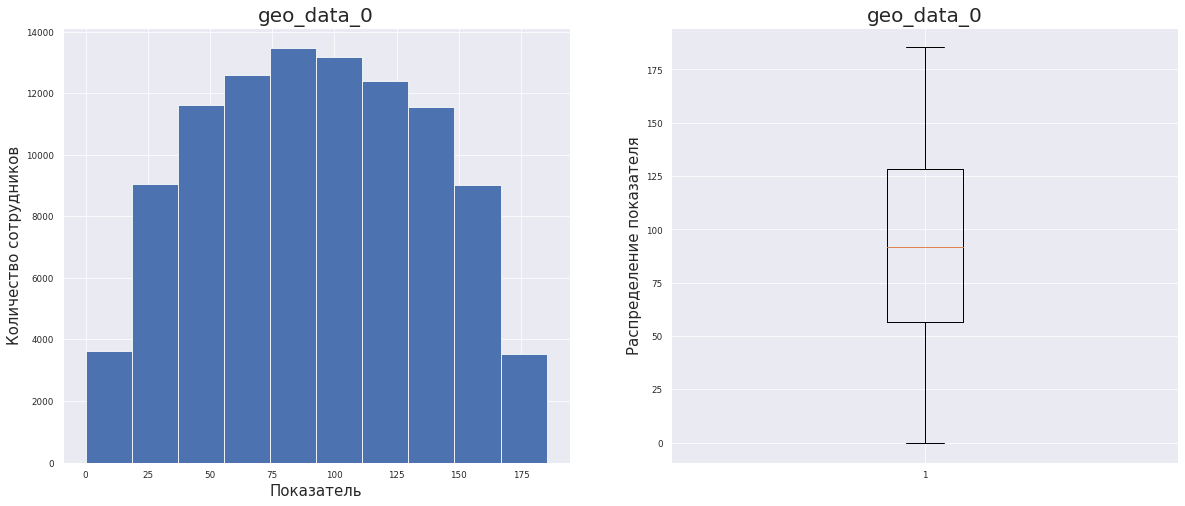

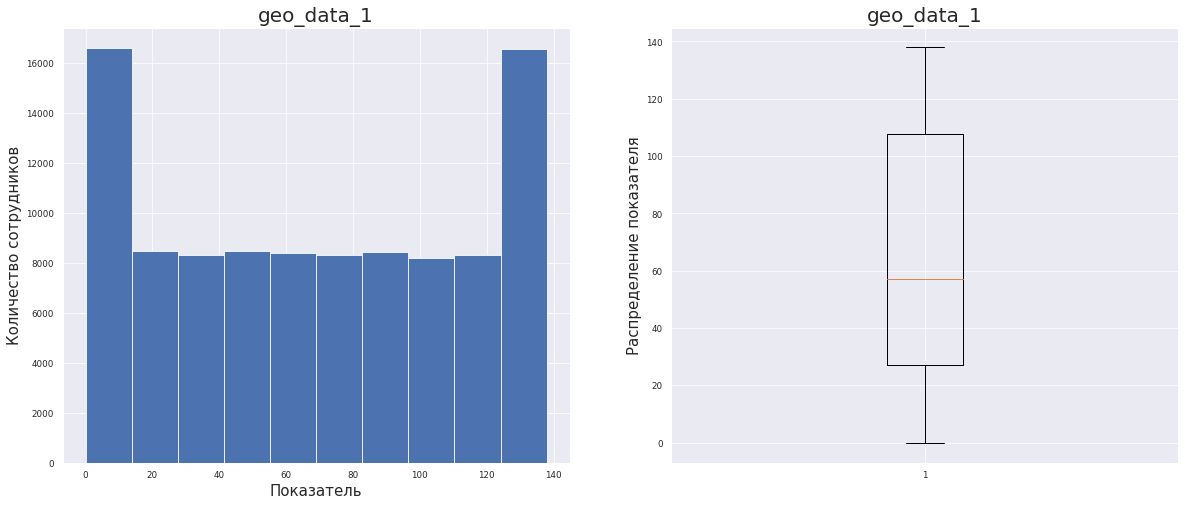

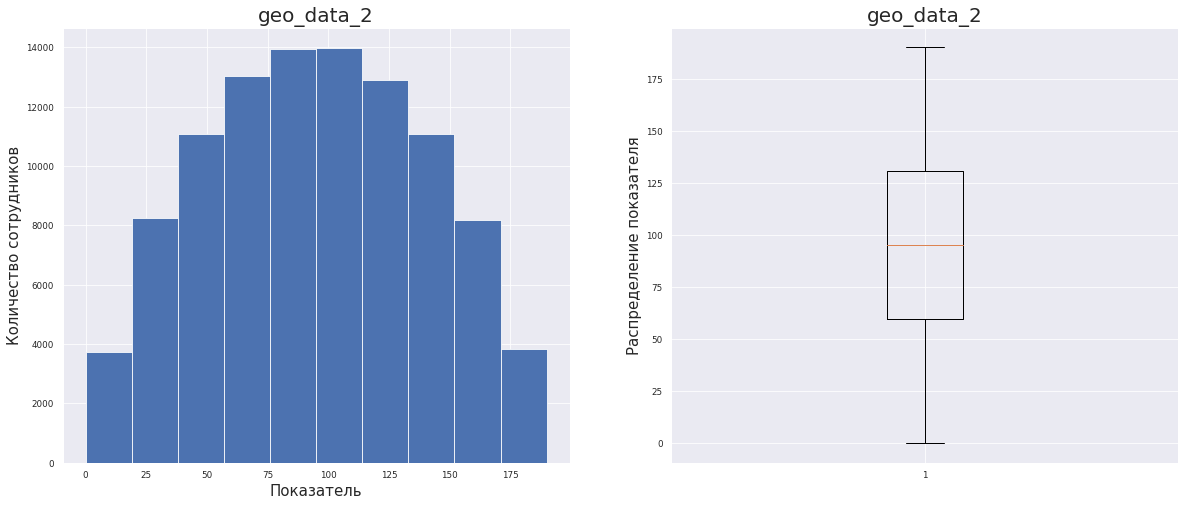

In [9]:
for name, df in plots.items(): 
    print('Распределение показателя: ',name,'\n\n\n')
    for col in df.columns:
        if col != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
            axes[0].hist(x=df[col])
            axes[0].set_title(col, fontsize=20)
            axes[0].set_xlabel('Показатель', fontsize=15)
            axes[0].set_ylabel('Количество сотрудников', fontsize=15)
            
            axes[1].boxplot(x=df[col])
            axes[1].set_title(col, fontsize=20)
            axes[1].set_xlabel(' ')
            axes[1].set_ylabel('Распределение показателя', fontsize=15)
            
            plt.show()


#### Вывод

По итогу исследовательского анализа данных можно заметить:
- Распределение показателей в разных локациях очень не равномерное
- Даже при похожих медианных значениях показателей, дисперсия очень высокая
- В локации 2 самые высокие показатели по объемам запасов и медианное значение близится к 100 ед.

#### Корреляционный анализ

geo_data_0


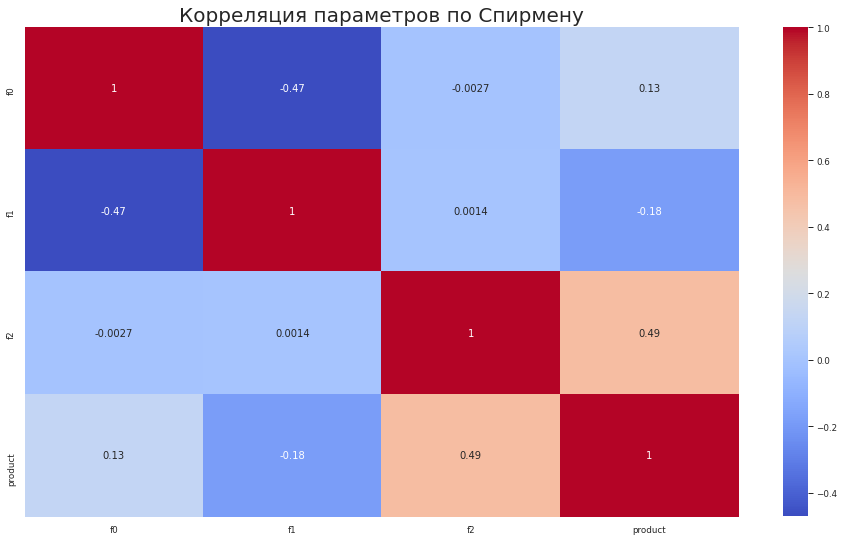

geo_data_1


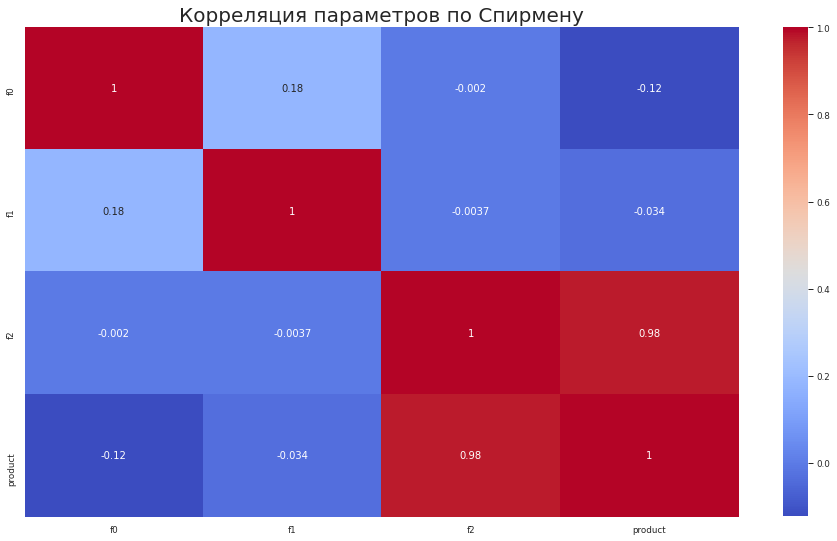

geo_data_2


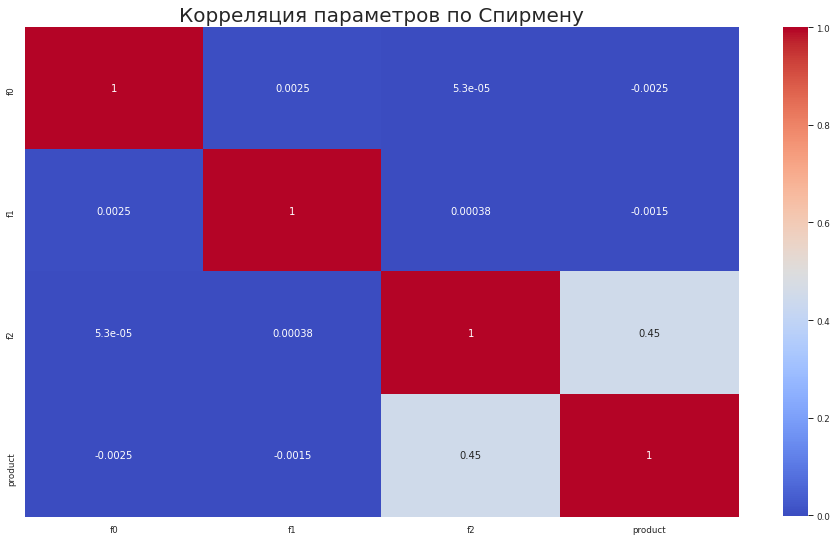

In [10]:
for name,df in data.items():
    print(name)
    full = df.drop('id',axis=1)
    full = sns.heatmap(full.corr(method = 'spearman'), annot=True, cmap='coolwarm')
    full.set_title('Корреляция параметров по Спирмену', fontsize=20)
    plt.show()

#### Вывод

В результате корреляционного анализа можно заключить:

- Самая большая линейная взаимосвязь у целевого признака наблюдается с показателем f2
- Мультиколлинеарности вводных параметров не обнаружено

<a id='5-topoc'></a>
## Обучение и проверка модели

#### Обучение модели для региона: 0

In [11]:
geo_data_0 = geo_data_0.set_index('id')
geo_data_1 = geo_data_1.set_index('id')
geo_data_2 = geo_data_2.set_index('id')

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    geo_data_0.drop(['product'], axis=1),  #  данные без целевого признака
    geo_data_0['product'],  #  целевой признак
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

In [13]:
def custom_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

neg_score = make_scorer(custom_metric, greater_is_better=True)

num_columns = ['f0', 'f1','f2']
param_grid = [
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([('num', MinMaxScaler(), num_columns)], remainder='passthrough')


# создайте итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression(fit_intercept=True, normalize=True))
    ]
)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=neg_score,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)



print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', -randomized_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели, полученная с помощью кросс-валидации: -37.67200536313506


Метрика RMSE: 37.76
Средний запас предсказанного сырья: 92


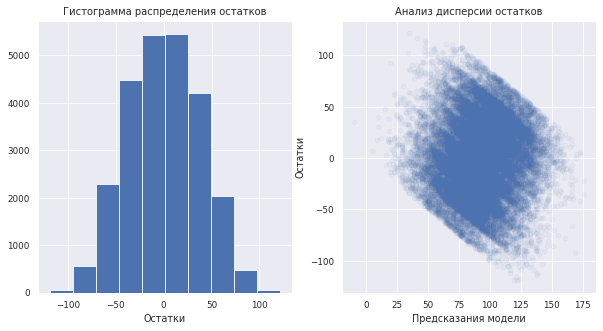

In [14]:
y_valid_pred = randomized_search.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_rounded = round(rmse, 2)

print(f'Метрика RMSE: {rmse_rounded}')
pred_0 = y_valid_pred
print ('Средний запас предсказанного сырья:', int(pred_0.mean()))


residuals = y_valid - y_valid_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_valid_pred, residuals, alpha=0.05)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()


In [15]:
pred_0_df = pd.DataFrame(randomized_search.predict(geo_data_0.drop(['product'], axis=1))).set_index(geo_data_0.index)

#### Обучение модели для региона: 1

In [16]:
X_train, X_valid, y_train, y_valid  = train_test_split(
    geo_data_1.drop(['product'], axis=1),
    geo_data_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

randomized_search_1 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=neg_score,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_1.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', -randomized_search_1.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели, полученная с помощью кросс-валидации: -0.8904559629285675


Метрика RMSE: 0.89
Средний запас предсказанного сырья: 68


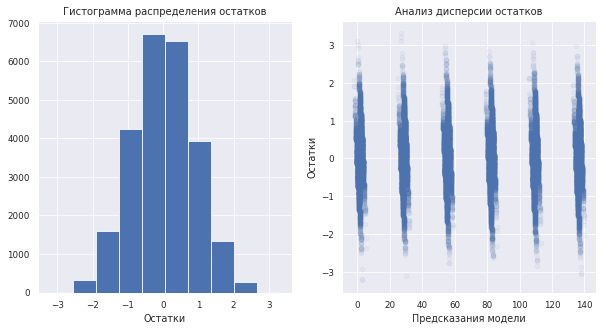

In [17]:
y_valid_pred = randomized_search_1.predict(X_valid)


rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_rounded = round(rmse, 2)

print(f'Метрика RMSE: {rmse_rounded}')
pred_1 = y_valid_pred
print ('Средний запас предсказанного сырья:', int(pred_1.mean()))

residuals = y_valid - y_valid_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_valid_pred, residuals, alpha=0.05)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()

In [18]:
pred_1_df = pd.DataFrame(randomized_search_1.predict(geo_data_1.drop(['product'], axis=1))).set_index(geo_data_1.index)

#### Обучение модели для региона: 2

In [19]:
X_train, X_valid, y_train, y_valid  = train_test_split(
    geo_data_2.drop(['product'], axis=1),
    geo_data_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

randomized_search_2 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=neg_score,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', -randomized_search_2.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели, полученная с помощью кросс-валидации: -40.02698159997838


Метрика RMSE: 40.15
Средний запас предсказанного сырья: 94


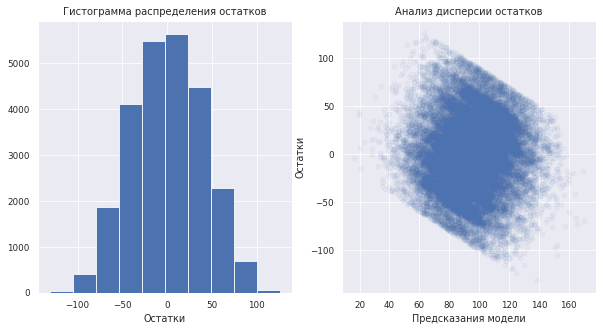

In [20]:
y_valid_pred = randomized_search_2.predict(X_valid)


rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_rounded = round(rmse, 2)

print(f'Метрика RMSE: {rmse_rounded}') 
pred_2 = y_valid_pred
print ('Средний запас предсказанного сырья:', int(pred_2.mean()))

residuals = y_valid - y_valid_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_valid_pred, residuals, alpha=0.05)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()

In [21]:
pred_2_df = pd.DataFrame(randomized_search_2.predict(geo_data_2.drop(['product'], axis=1))).set_index(geo_data_2.index)

#### Вывод

Было обучено три модели линейной регрессии с использованием разных способов масштабирования численных параметров. 
Метрика по регионам 0 и 2 порядка 40. Метрика по 1 региону 0.89, так как сильная корреляция одного из вводных параметров с целевым.

- Средний запас предсказанного сырья для региона 0: 92
- Средний запас предсказанного сырья для региона 1: 68
- Средний запас предсказанного сырья для региона 1: 94

<a id='6-topoc'></a>
## Подготовка к расчёту прибыли

#### Расчет среднего объема запасов по регионам

In [22]:
pred_0 = pd.DataFrame(pred_0)
pred_1 = pd.DataFrame(pred_1)
pred_2 = pd.DataFrame(pred_2)

data = {
    'geo_data_0':geo_data_0,
    'geo_data_1':geo_data_1,
    'geo_data_2':geo_data_2
    
}

In [23]:
geo_data_0_mean = int(geo_data_0['product'].mean())
print('Средний объем запасов в скважинах по региону 0: ',round(geo_data_0_mean,2),'(тыс. баррелей)')

geo_data_1_mean = int(geo_data_1['product'].mean())
print('Средний объем запасов в скважинах по региону 1: ',round(geo_data_1_mean,2),'(тыс. баррелей)')

geo_data_2_mean = int(geo_data_2['product'].mean())
print('Средний объем запасов в скважинах по региону 2: ',round(geo_data_2_mean,2),'(тыс. баррелей)')

Средний объем запасов в скважинах по региону 0:  92 (тыс. баррелей)
Средний объем запасов в скважинах по региону 1:  68 (тыс. баррелей)
Средний объем запасов в скважинах по региону 2:  95 (тыс. баррелей)


#### Расчет объема необходимого для безубыточной разработки

In [24]:
best_way = (1*10**10/450000)/200
print('Для безубыточной разработки новой скважиты требуется объем выработки не меньше: ',best_way,'(тыс. баррелей)')

Для безубыточной разработки новой скважиты требуется объем выработки не меньше:  111.11111111111111 (тыс. баррелей)


#### Сравнение расчетного объема с средним по региону

In [25]:
geo_data_0_final = (geo_data_0_mean/best_way)
print(geo_data_0_final)

geo_data_1_final = (geo_data_1_mean/best_way)
print(geo_data_1_final)

geo_data_2_final = (geo_data_2_mean/best_way)
print(geo_data_2_final)

0.828
0.612
0.855


#### Вывод

- Средний объем запасов в скважинах по региону 0:  92 (тыс. баррелей)
- Средний объем запасов в скважинах по региону 1:  68 (тыс. баррелей)
- Средний объем запасов в скважинах по региону 2:  95 (тыс. баррелей)

<a id='7-topoc'></a>
## Расчёт прибыли

In [26]:
pred_0_sum = pred_0.sort_values(by=0,ascending=False).reset_index(drop=True)
pred_0_sum = pred_0_sum.loc[:199]
pred_0_sum = pred_0_sum.sum()
print('Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 0: ',int(pred_0_sum))
print('Прибыль от полученного объема сырья: ',int(pred_0_sum*450000 -(1*10**10)))

pred_1_sum = pred_1.sort_values(by=0,ascending=False).reset_index(drop=True)
pred_1_sum = pred_1_sum.loc[:199]
pred_1_sum = pred_1_sum.sum()
print('Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 1: ',int(pred_1_sum))
print('Прибыль от полученного объема сырья: ',int(pred_1_sum*450000 - (1*10**10)))

pred_2_sum = pred_2.sort_values(by=0,ascending=False).reset_index(drop=True)
pred_2_sum = pred_2_sum.loc[:199]
pred_2_sum = pred_2_sum.sum()
print('Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 2: ',int(pred_2_sum))
print('Прибыль от полученного объема сырья: ',int(pred_2_sum*450000 - (1*10**10)))

Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 0:  30881
Прибыль от полученного объема сырья:  3896658479
Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 1:  27748
Прибыль от полученного объема сырья:  2486938114
Суммарный объем 200-от скважин с максимальными значениями предсказаний для региона 2:  29728
Прибыль от полученного объема сырья:  3377981513


#### Вывод

<a id='8-topoc'></a>
## Расчёт рисков 

 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [27]:
barrel_price = 450000  # Цена за баррель
budget = 1*10**10  # Затраты на бурение
max_points = 500  # Максимальное количество точек в бутстрап-выборке
final_points = 200  # Фиксированное количество точек для расчета прибыли 

In [28]:
def profit(target, probabilities, count, barrel_price, budget):
    
#     sorted_probabilities = probabilities.sort_values(by=probabilities.columns[0], ascending=False)  
#     selected = target.iloc[:count] 
#     return int(barrel_price * selected.sum() - budget)

    prob_sort = probabilities.sort_values(by=probabilities.columns[0], ascending=False) 
    selected = target[prob_sort.index][:count]
    return int(barrel_price * selected.sum() - budget)



def bootstrap(true, predicted, final_points, barrel_price, budget):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        true_subsample = pd.Series(true).sample(n=max_points, replace=True, random_state=state)
        pred_subsample = predicted.loc[true_subsample.index]
        values.append(profit(true_subsample, 
                            pred_subsample,
                            final_points,
                            barrel_price,
                            budget))
        
    values = pd.Series(values)
    values_mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()
    return values_mean, lower, upper, risk 


geo_data_0 = geo_data_0[~geo_data_0.index.duplicated(keep='first')] 
predicted = pred_0_df

target = geo_data_0['product']  # Действительный объем нефти
predicted = pred_0_df  # Предсказанный объем нефти (из модели)

values_mean_0, lower_0, upper_0, risk_0 = bootstrap(target, predicted, final_points, barrel_price, budget)

print('Показатели по локации 0:','\n\n')
print("Средняя прибыль:", values_mean_0)
print("Нижняя граница доверительного интервала:", lower_0)
print("Верхняя граница доверительного интервала:", upper_0)
print("Процент убытков:", risk_0,'\n\n\n')

geo_data_1 = geo_data_1[~geo_data_1.index.duplicated(keep='first')] 
predicted = pred_1_df

target = geo_data_1['product']
values_mean_1, lower_1, upper_1, risk_1 = bootstrap(target, predicted, final_points, barrel_price, budget)

print('Показатели по локации 1:','\n\n')
print("Средняя прибыль:", values_mean_1)
print("Нижняя граница доверительного интервала:", lower_1)
print("Верхняя граница доверительного интервала:", upper_1)
print("Процент убытков:", risk_1,'\n\n\n')

geo_data_2 = geo_data_2[~geo_data_2.index.duplicated(keep='first')] 
predicted = pred_2_df

target = geo_data_2['product']
values_mean_2, lower_2, upper_2, risk_2 = bootstrap(target, predicted, final_points, barrel_price, budget)

print('Показатели по локации 2:','\n\n')
print("Средняя прибыль:", values_mean_2)
print("Нижняя граница доверительного интервала:", lower_2)
print("Верхняя граница доверительного интервала:", upper_2)
print("Процент убытков:", risk_2)

Показатели по локации 0: 


Средняя прибыль: 431504874.982
Нижняя граница доверительного интервала: -58378688.17499999
Верхняя граница доверительного интервала: 913261081.75
Процент убытков: 0.046 



Показатели по локации 1: 


Средняя прибыль: 469233771.312
Нижняя граница доверительного интервала: 86645272.15
Верхняя граница доверительного интервала: 847961900.0
Процент убытков: 0.011 



Показатели по локации 2: 


Средняя прибыль: 370150650.418
Нижняя граница доверительного интервала: -172104425.325
Верхняя граница доверительного интервала: 905391552.5749999
Процент убытков: 0.094


<a id='9-topoc'></a>
## Общий вывод

Для проведения исследования предоставлены шесть датасетов.

**1) В ходе превичного изучения данных было сделано:**

Данные предоставлены хорошего качества, хорошо структурированы. Пропусков не обнаружено, название столбцов соответствует стандартам.

---

**2) В результате проведенного исследовательского анализа данных можно сделать следующие выводы:**

- Распределение показателей в разных локациях очень не равномерное
- Даже при похожих медианных значениях показателей, дисперсия очень высокая
- В локации 2 самые высокие показатели по объемам запасов и медианное значение близится к 100 ед.

По результатам корреляционного анализа было выявлено следующее:

- Самая большая линейная взаимосвязь у целевого признака наблюдается с показателем f2
- Мультиколлинеарности вводных параметров не обнаружено

---


**3) В результате обучения и проверки модели:**

Было обучено три модели линейной регрессии с использованием разных способов масштабирования численных параметров. 
Метрика по регионам 0 и 2 порядка 40. Метрика по 1 региону 0.89, так как сильная корреляция одного из вводных параметров с целевым.

- Средний запас предсказанного сырья для региона 0: 92
- Средний запас предсказанного сырья для региона 1: 68
- Средний запас предсказанного сырья для региона 1: 94

---

**4) В результате подгововки к расчету прибыли было выявлено:**

- Средний объем запасов в скважинах по региону 0:  92 (тыс. баррелей)
- Средний объем запасов в скважинах по региону 1:  68 (тыс. баррелей)
- Средний объем запасов в скважинах по региону 2:  95 (тыс. баррелей)

---

**5) В результате расчета прибыли были получены следующие значения:**

Показатели по локации 0: 


- Средняя прибыль: 431504874.982
- Нижняя граница доверительного интервала: -58378688.17499999
- Верхняя граница доверительного интервала: 913261081.75
- Процент убытков: 0.046 



Показатели по локации 1: 


- Средняя прибыль: 469233771.312
- Нижняя граница доверительного интервала: 86645272.15
- Верхняя граница доверительного интервала: 847961900.0
- Процент убытков: 0.011 



Показатели по локации 2: 


- Средняя прибыль: 370150650.418
- Нижняя граница доверительного интервала: -172104425.325
- Верхняя граница доверительного интервала: 905391552.5749999
- Процент убытков: 0.094

---

**6) По итогу проекта можно заключить:**

- В регионе 1 самая высокая средняя прибыль, поэтому этот регион предпочтителен для разработки
- По 1 локкации процент убытков не превышает 2%, это допустимо для проекта
- По остальным локациям процент убытков достаточно велик, поэтому разработка не желательна
